In [1]:
#from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize']=(10,18)
%matplotlib inline
from datetime import datetime
from datetime import date
#import xgboost as xgb
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns # plot beautiful charts
import warnings
import math
sns.set()
warnings.filterwarnings('ignore')

In [2]:
data_train = pd.read_csv('input/train.csv').drop(columns=['dropoff_datetime'])
data_test = pd.read_csv('input/test.csv')

#data_train.head()
#. Add fastest routes and merge them into the origial dataframe
data_train_fastroute1 = pd.read_csv('input/fastest_routes_train_part_1.csv',
                        usecols=['id', 'total_distance','number_of_steps',  'step_location_list'])
data_train_fastroute2 = pd.read_csv('input/fastest_routes_train_part_2.csv',
                        usecols=['id', 'total_distance','number_of_steps',  'step_location_list'])
data_train_fastroute = pd.concat((data_train_fastroute1,data_train_fastroute2))
data_train = data_train.join(data_train_fastroute.set_index('id'), on='id')
data_train = data_train.dropna()
#print()
data_train.head()
# Clean rows that have null values

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,total_distance,number_of_steps,step_location_list
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2009.1,5.0,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2513.2,6.0,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11060.8,16.0,"-73.978874,40.764148|-73.977685,40.763646|-73...."
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1779.4,4.0,"-74.010145,40.719982|-74.011527,40.714294|-74...."
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1614.9,5.0,"-73.972998,40.793187|-73.976607,40.788361|-73...."


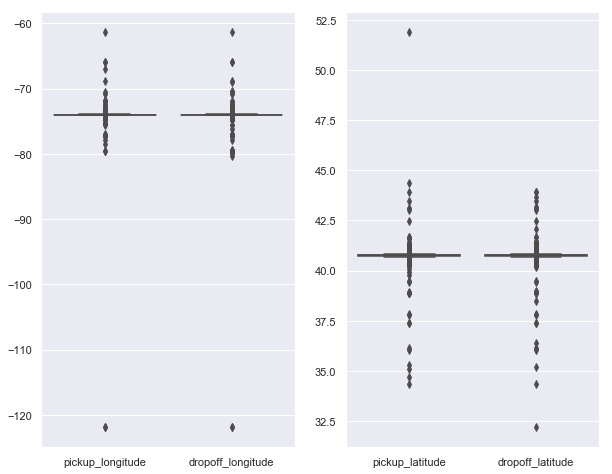

In [27]:
fig=plt.figure(figsize=(10, 8))
for i,loc in enumerate((['pickup_longitude','dropoff_longitude'],['pickup_latitude','dropoff_latitude'])):
    plt.subplot(1,2,i+1)
    sns.boxplot(data=data_train,order=loc);#plt.title(loc)

In [28]:
#. Extracting and visualize these anomalous trips
#. Add a column to indicate whether a certain trip is anomalous or not
anomaly_cols = np.array([False]*len(data_train))
anomaly_cols[data_train.pickup_longitude<-110]=True
anomaly_cols[data_train.pickup_longitude>-63]=True
anomaly_cols[data_train.dropoff_longitude<-110]=True
anomaly_cols[data_train.dropoff_longitude>-63]=True
anomaly_cols[data_train.pickup_latitude>45]=True
anomaly_cols[data_train.dropoff_latitude<32.5]=True
print('There are total %d entries of ouliers'% sum(anomaly_cols))
print(data_train.pickup_longitude.type)

There are total 5 entries of ouliers


In [39]:
import folium
basemap = folium.Map(location=[40.767937,-73.982155 ],tiles='OpenStreetMap',
 zoom_start=12)
#. Extract trajectory from anomaly rows
data_train = data_train.assign(anomaly=anomaly_cols)
trips_anomaly = data_train[data_train['anomaly']==True]
trips_anomaly.head(5)

trj_list_anomaly = []
for index,row_anomaly in trips_anomaly.iterrows():
    route = row_anomaly['step_location_list']
    trj = route.split('|')
    gps_list = []
    for gps_loc in trj:
        gps_log_lat_string = gps_loc.split(',')
        gps_log_lat = [float(element) for element in gps_log_lat_string]
        gps_list.append([gps_log_lat[0],gps_log_lat[1]])
        #step_index++
    trj_list_anomaly.append(gps_list)
#print(trj_list_anomaly)    

#. Visualize anomalous trips
for trj in trj_list_anomaly:
    for loc in trj:
        folium.CircleMarker([loc[1],loc[0]],
                        radius=3,
                        color='red',
                        popup=str(loc[1])+','+str(loc[0]),
                        fill_color='#FD8A6C'
                        ).add_to(basemap)
    
basemap